<a href="https://colab.research.google.com/github/Dollyp1205/Marketing-Research-Methods---Dolly-Poddar--Jio-Institute/blob/Session-10/Simulation_based_on_Ad_Stock_and_Ad_Saturation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Summary Statistics:
           Mean Ad Spend  Mean Ad Stock  Mean Effect  Effect StdDev
Instagram        1006.23        4973.95         0.83           0.02
Snapchat          807.82        2675.10         0.77           0.02
YouTube          1514.44       14770.20         0.91           0.03

Overall ROI: 454.85%


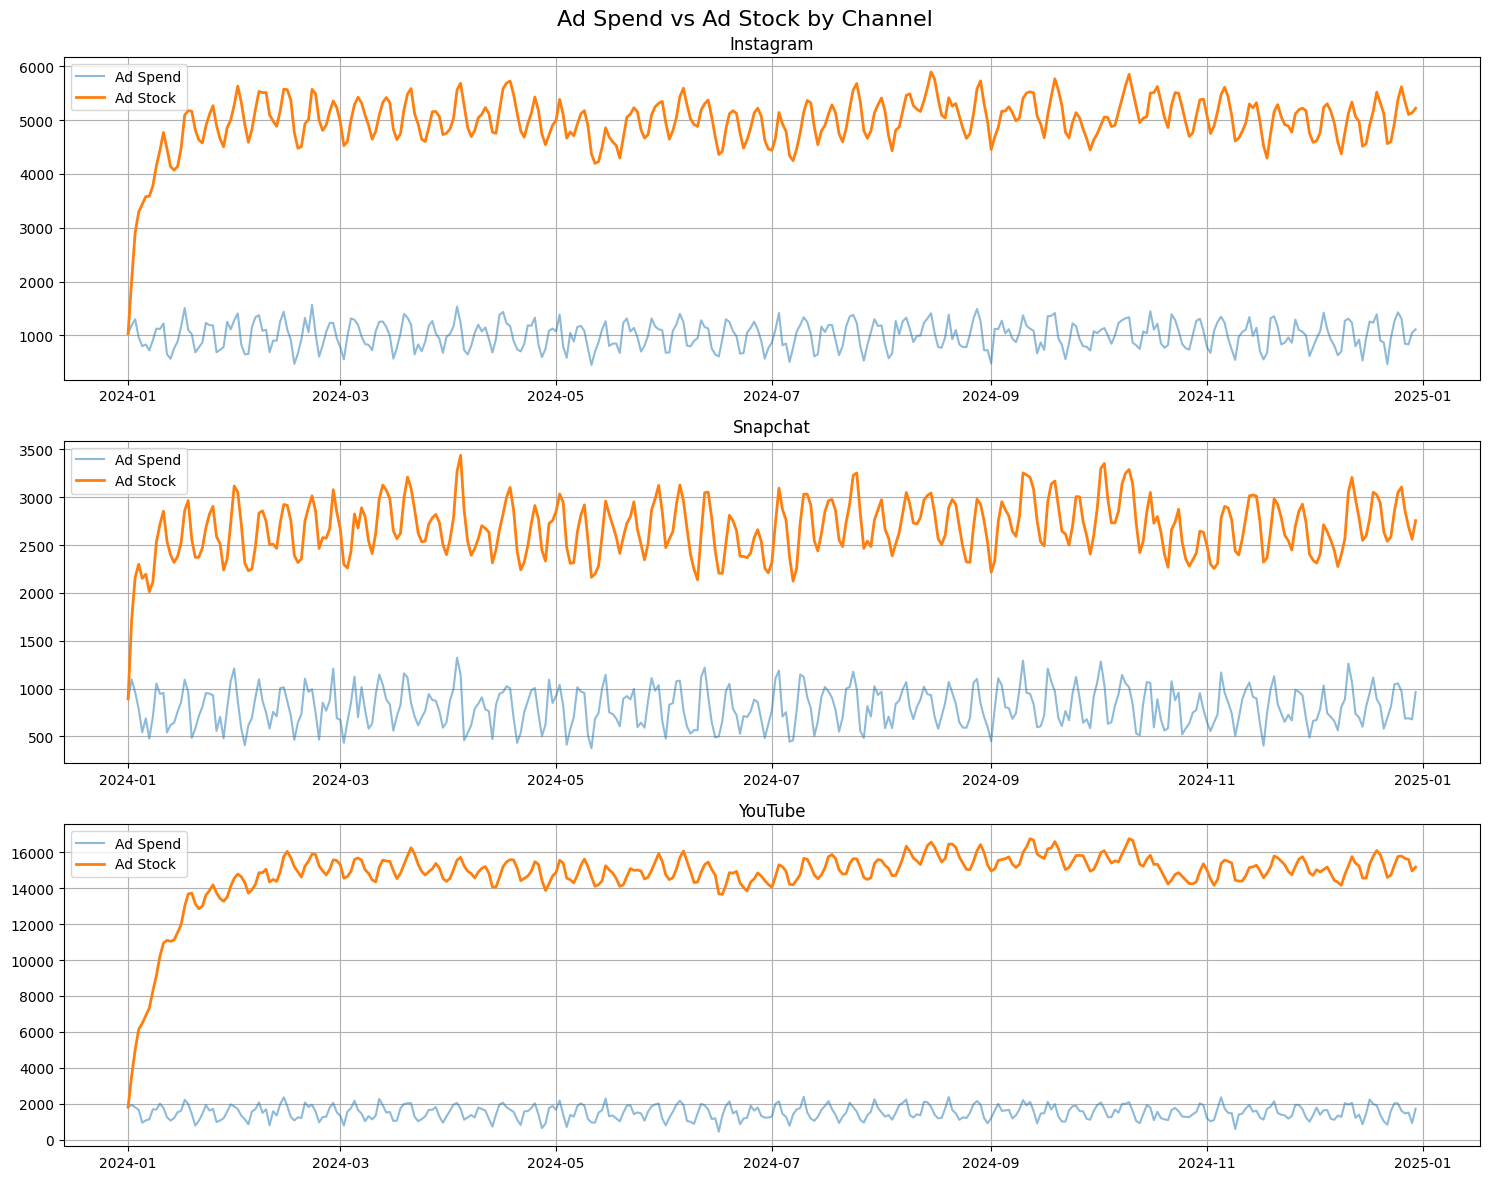

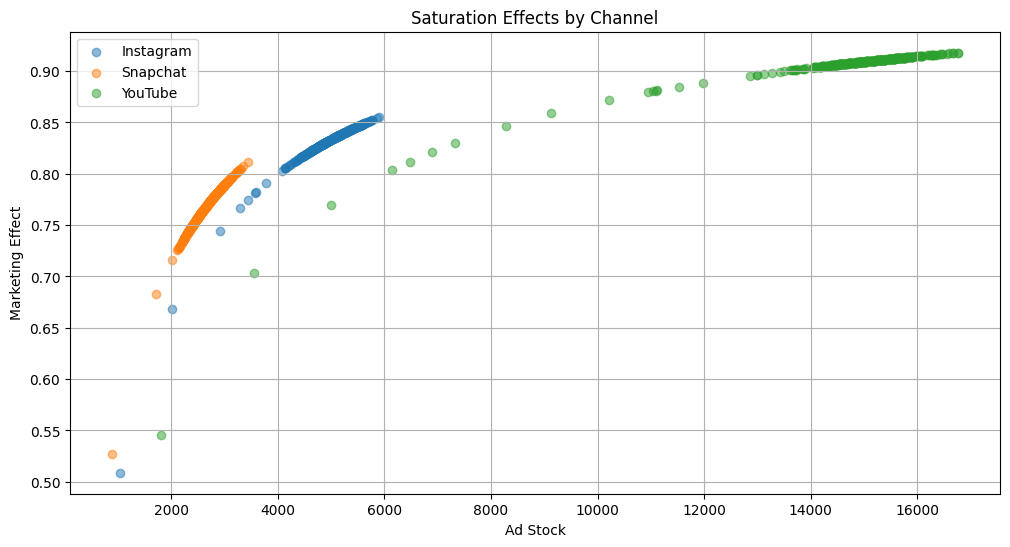

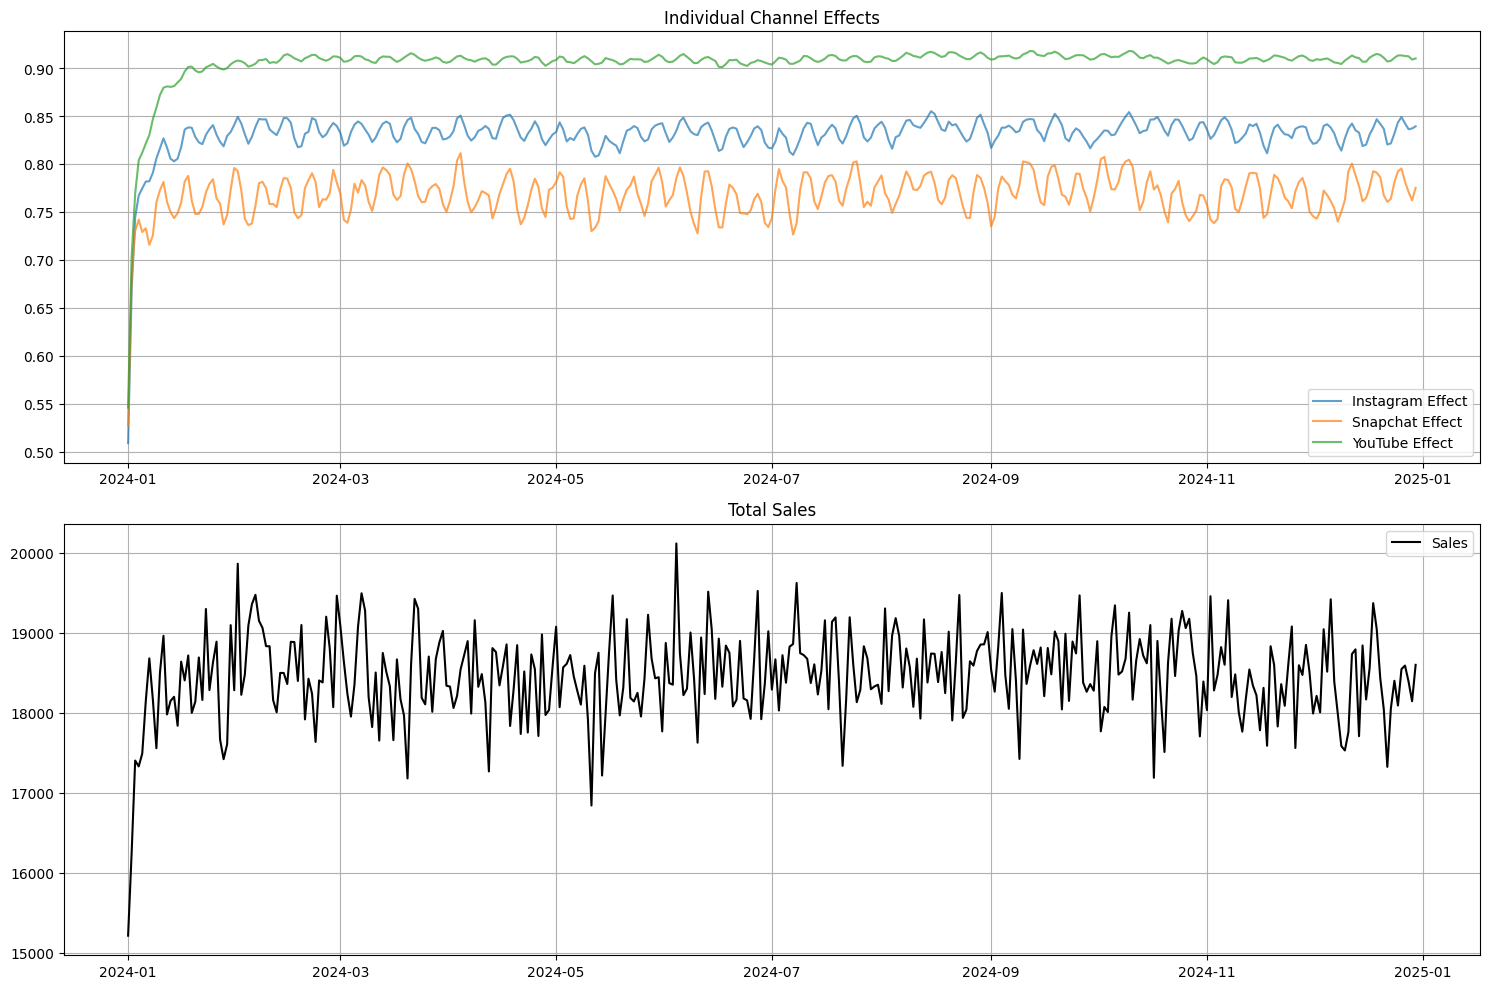

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
def generate_ad_spend(n_periods=365):
    """Generate synthetic ad spend data with weekly patterns and random noise"""
    base_spend = {
        'Instagram': 1000,
        'Snapchat': 800,
        'YouTube': 1500
    }

    data = []
    start_date = datetime(2024, 1, 1)

    for i in range(n_periods):
        current_date = start_date + timedelta(days=i)
        # Add weekly seasonality and random noise
        daily_mult = 1 + 0.3 * np.sin(2 * np.pi * i / 7) + np.random.normal(0, 0.1)

        daily_data = {
            'date': current_date,
            'Instagram': max(0, base_spend['Instagram'] * daily_mult + np.random.normal(0, 100)),
            'Snapchat': max(0, base_spend['Snapchat'] * daily_mult + np.random.normal(0, 80)),
            'YouTube': max(0, base_spend['YouTube'] * daily_mult + np.random.normal(0, 150))
        }
        data.append(daily_data)

    return pd.DataFrame(data)

# Calculate ad stock (carryover effect)
def calculate_ad_stock(spend, decay_rate=0.8):
    """Calculate ad stock using geometric decay"""
    ad_stock = np.zeros_like(spend)
    ad_stock[0] = spend[0]

    for t in range(1, len(spend)):
        ad_stock[t] = spend[t] + decay_rate * ad_stock[t-1]

    return ad_stock

# Apply diminishing returns (saturation effect)
def apply_saturation(ad_stock, half_saturation=1000):
    """Apply saturation effect using Hill function"""
    return ad_stock / (ad_stock + half_saturation)

# Generate base data
df = generate_ad_spend()

# Calculate ad stock and saturation effects
channels = ['Instagram', 'Snapchat', 'YouTube']
decay_rates = {'Instagram': 0.8, 'Snapchat': 0.7, 'YouTube': 0.9}
half_saturation = {'Instagram': 1000, 'Snapchat': 800, 'YouTube': 1500}

for channel in channels:
    # Calculate ad stock
    df[f'{channel}_stock'] = calculate_ad_stock(
        df[channel].values,
        decay_rate=decay_rates[channel]
    )

    # Calculate saturation effect
    df[f'{channel}_effect'] = apply_saturation(
        df[f'{channel}_stock'],
        half_saturation=half_saturation[channel]
    )

# Calculate total marketing effect
# We'll use different weights for each channel
channel_weights = {'Instagram': 0.35, 'Snapchat': 0.25, 'YouTube': 0.4}
df['total_effect'] = sum(
    df[f'{channel}_effect'] * weight
    for channel, weight in channel_weights.items()
)

# Add some baseline sales and noise
base_sales = 10000
sales_noise = np.random.normal(0, 500, len(df))
df['sales'] = base_sales * (1 + df['total_effect']) + sales_noise

# Plotting functions
def plot_ad_spend_and_stock():
    """Plot original ad spend and calculated ad stock"""
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle('Ad Spend vs Ad Stock by Channel', fontsize=16)

    for idx, channel in enumerate(channels):
        axes[idx].plot(df['date'], df[channel],
                      label='Ad Spend', alpha=0.5)
        axes[idx].plot(df['date'], df[f'{channel}_stock'],
                      label='Ad Stock', linewidth=2)
        axes[idx].set_title(f'{channel}')
        axes[idx].legend()
        axes[idx].grid(True)

    plt.tight_layout()
    return fig

def plot_saturation_effects():
    """Plot saturation effects for each channel"""
    fig, ax = plt.subplots(figsize=(12, 6))

    for channel in channels:
        ax.scatter(df[f'{channel}_stock'], df[f'{channel}_effect'],
                  alpha=0.5, label=channel)

    ax.set_xlabel('Ad Stock')
    ax.set_ylabel('Marketing Effect')
    ax.set_title('Saturation Effects by Channel')
    ax.legend()
    ax.grid(True)

    return fig

def plot_sales_and_effects():
    """Plot sales and marketing effects over time"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot individual channel effects
    for channel in channels:
        ax1.plot(df['date'], df[f'{channel}_effect'],
                label=f'{channel} Effect', alpha=0.7)

    ax1.set_title('Individual Channel Effects')
    ax1.legend()
    ax1.grid(True)

    # Plot total sales
    ax2.plot(df['date'], df['sales'], label='Sales', color='black')
    ax2.set_title('Total Sales')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    return fig

# Generate plots
fig1 = plot_ad_spend_and_stock()
fig2 = plot_saturation_effects()
fig3 = plot_sales_and_effects()

# Calculate and print summary statistics
summary_stats = pd.DataFrame({
    'Mean Ad Spend': [df[channel].mean() for channel in channels],
    'Mean Ad Stock': [df[f'{channel}_stock'].mean() for channel in channels],
    'Mean Effect': [df[f'{channel}_effect'].mean() for channel in channels],
    'Effect StdDev': [df[f'{channel}_effect'].std() for channel in channels]
}, index=channels)

print("\nSummary Statistics:")
print(summary_stats.round(2))

# Calculate ROI metrics
total_spend = sum(df[channel].sum() for channel in channels)
total_sales = df['sales'].sum()
roi = (total_sales - total_spend) / total_spend

print(f"\nOverall ROI: {roi:.2%}")

# Save plots
fig1.savefig('ad_spend_and_stock.png')
fig2.savefig('saturation_effects.png')
fig3.savefig('sales_and_effects.png')

plt.show()